In [2]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output

## FlightTracker init

In [63]:
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

start_time='2023-01-01 00:00:00'
stop_time='2024-01-01 00:00:00'
tracker = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db', already_calculated = True)
flights = tracker.flights
flights_distinct = tracker.flights_distinct
flights_distinct = sqldf('SELECT *, substr(flightnumber, 1, 3) as airline FROM flights_distinct')
flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,airline
0,4128,CLX17K,2023-01-01,2023.01.01-040336.db,2023-01-01 01:07:57.300000,2023-01-01 01:11:38.400000,112.5,8.6,87.0,CLX
1,4129,AFR271,2023-01-01,2023.01.01-040336.db,2023-01-01 01:14:44.300000,2023-01-01 01:22:31.500000,12.0,10.2,79.0,AFR
2,4130,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 01:18:45.400000,2023-01-01 01:18:45.400000,146.6,8.1,0.0,N/A
3,4131,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 08:34:32.500000,2023-01-01 17:34:45.100000,109.1,8.7,54.0,N/A
4,4132,BOX488,2023-01-01,2023.01.01-040336.db,2023-01-01 01:18:50.500000,2023-01-01 01:24:37.100000,72.6,8.1,82.0,BOX
...,...,...,...,...,...,...,...,...,...,...
6890,754,THY9WC,2023-12-31,2023.12.31-171747.db,2023-12-31 09:01:14.600000,2023-12-31 09:04:35.600000,118.0,9.5,88.0,THY
6891,755,SAS936,2023-12-31,2023.12.31-171747.db,2023-12-31 10:37:47.800000,2023-12-31 10:43:44.500000,26.6,10.7,86.0,SAS
6892,756,ACA78,2023-12-31,2023.12.31-171747.db,2023-12-31 10:50:01.400000,2023-12-31 10:52:27.100000,138.3,8.9,89.0,ACA
6893,757,AFR291,2023-12-31,2023.12.31-171747.db,2023-12-31 15:59:06.500000,2023-12-31 16:07:23.900000,14.1,9.9,75.0,AFR


## Number of flights per airline (in radius)

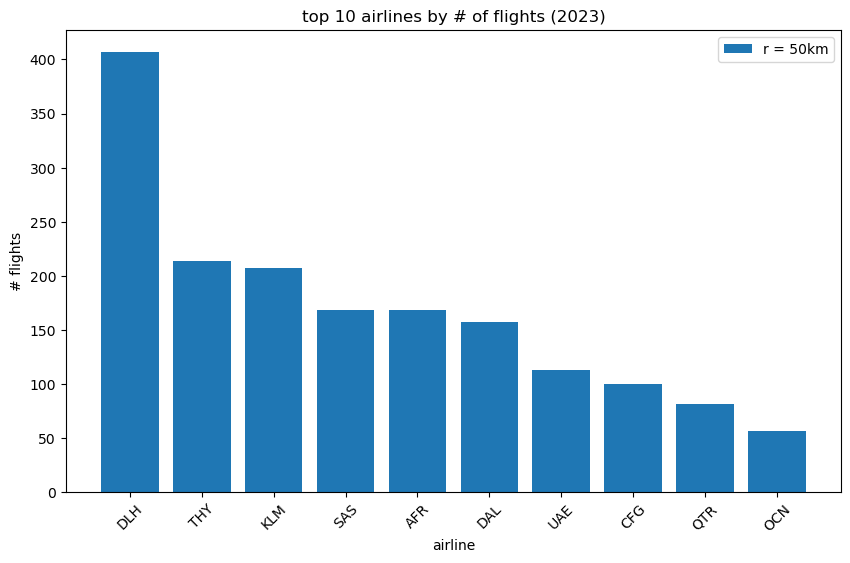

<Figure size 640x480 with 0 Axes>

In [55]:
radius = 50
query = f'''
SELECT 
    airline
    ,count(airline) as count
FROM (
    SELECT 
        substr(flightnumber, 1, 3) as airline 
    FROM flights_distinct
    WHERE min_r < {radius}
)t0
GROUP BY airline
ORDER BY count(airline) desc

'''


result = sqldf(query)
top_10 = result.head(10)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(top_10['airline'], top_10['count'], label ='r = 50km')
plt.title('top 10 airlines by # of flights (2023)')
plt.legend()
plt.xlabel('airline')
plt.ylabel('# flights')
plt.xticks(rotation=45)
plt.show()
#plt.savefig('saved_figures/top_10_airlines_50km_2023.pdf')

In [59]:
radius = 50
query = f'''
SELECT 
    airline
    ,min(theta) as min_theta
    ,max(theta) as max_theta
FROM (
    SELECT 
        substr(flightnumber, 1, 3) as airline 
        ,theta
    FROM flights_distinct
    WHERE min_r < {radius}
)t0
--Where airline = "DLH"
GROUP BY airline
ORDER BY count(airline) desc

'''


result = sqldf(query)
result

,airline,min_theta,max_theta
0,DLH,84.0,90.0
1,THY,86.0,90.0
2,KLM,75.0,90.0
3,SAS,86.0,87.0
4,AFR,72.0,88.0
...,...,...,...
84,CGE,78.0,78.0
85,CFM,83.0,83.0
86,BTX,90.0,90.0
87,BLX,88.0,88.0


## Get trajectories for 1 airline

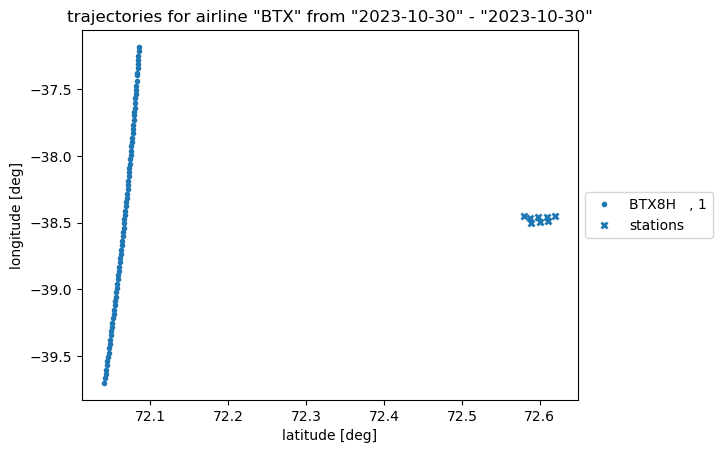

In [64]:
airline = 'BTX'
flights_one_airline = flights[flights.flightnumber.str.startswith(airline)]
flights_one_airline_distinct = flights_distinct[flights_distinct.flightnumber.str.startswith(airline)]

flightnumbers = sqldf(f'Select distinct flightnumber from flights_one_airline_distinct where min_r < {radius}')

for i in range(len(flightnumbers)):
    number_of_flights = sqldf(f'Select count(flightnumber) as counter from flights_one_airline_distinct Where flightnumber like "%{flightnumbers.flightnumber.iloc[i]}%" group By flightnumber')
    plt.plot(flights_one_airline[flights_one_airline.flightnumber == flightnumbers.flightnumber.iloc[i]].latitude, flights_one_airline[flights_one_airline.flightnumber == flightnumbers.flightnumber.iloc[i]].longitude, '.', label = f'{flightnumbers.flightnumber.iloc[i]}, {number_of_flights.counter.iloc[0]}')
plt.plot(tracker.stations.latitude, tracker.stations.longitude, 'x', label = 'stations', markersize = 5, markeredgewidth=2, c = 'C0')
plt.title(f'trajectories for airline "{airline}" from "{min(flights_one_airline.date)}" - "{max(flights_one_airline.date)}"')
plt.xlabel('latitude [deg]')
plt.ylabel('longitude [deg]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Number of flights per day (for 4 radii)

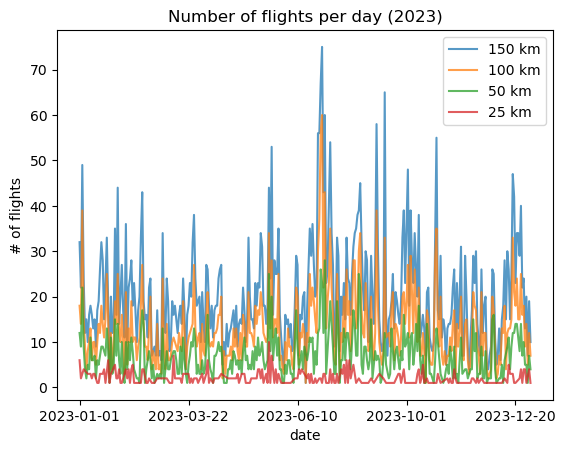

In [24]:
def query(min_r):

    return f'''
    Select 
        date, 
        count(flightnumber) as counter
    from flights_distinct
    Where min_r < {min_r}
    Group By date
    '''

import matplotlib.ticker as ticker
for i in [150, 100, 50, 25]:
    flights_per_day = sqldf(query(i))
    plt.plot(flights_per_day.date, flights_per_day.counter, label = f'{i} km', alpha = 0.75)
    plt.title('Number of flights per day (2023)')
plt.xlabel('date')
plt.ylabel('# of flights')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.savefig('saved_figures/flights_per_day_2023.pdf')

In [70]:
flights_distinct['datetime_date'] = pd.to_datetime(flights_distinct.date)
flights_distinct['iso_day'] = flights_distinct.datetime_date.dt.isocalendar().day
flights_distinct['iso_month'] = flights_distinct.datetime_date.dt.month

## Number of flights per weekday (4 radii)

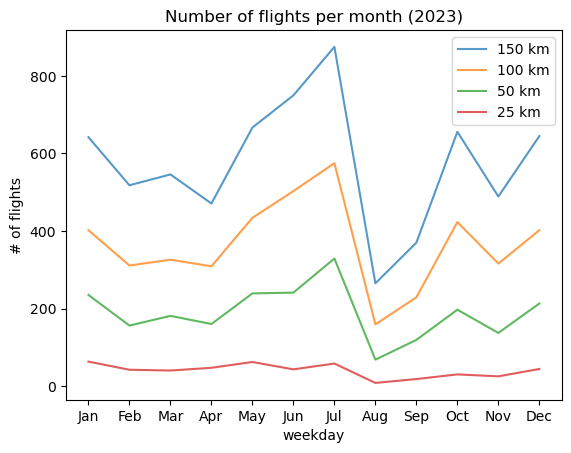

In [46]:
def query(min_r):

    return f'''
    Select 
        iso_month, 
        count(flightnumber) as counter
    from flights_distinct
    Where min_r < {min_r}
    Group By iso_month
    '''

import matplotlib.ticker as ticker
for i in [150, 100, 50, 25]:
    flights_per_day = sqldf(query(i))
    plt.plot(flights_per_day.iso_month, flights_per_day.counter, label = f'{i} km', alpha = 0.75)
    plt.title('Number of flights per month (2023)')
plt.xlabel('weekday')
plt.ylabel('# of flights')
plt.legend()
# Customizing the x-axis to show Mo-Su
months_of_year = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(range(1, 13)))
plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(months_of_year))

#plt.savefig('saved_figures/flights_per_month_2023.pdf')

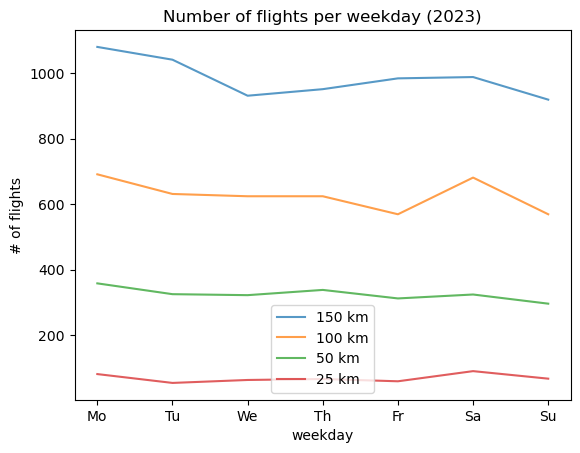

In [72]:
def query(min_r):

    return f'''
    Select 
        iso_day, 
        count(flightnumber) as counter
    from flights_distinct
    Where min_r < {min_r}
    Group By iso_day
    '''

import matplotlib.ticker as ticker
for i in [150, 100, 50, 25]:
    flights_per_day = sqldf(query(i))
    plt.plot(flights_per_day.iso_day, flights_per_day.counter, label = f'{i} km', alpha = 0.75)
    plt.title('Number of flights per weekday (2023)')
plt.xlabel('weekday')
plt.ylabel('# of flights')
plt.legend()
# Customizing the x-axis to show Mo-Su
days_of_week = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
plt.gca().xaxis.set_major_locator(ticker.FixedLocator([1, 2, 3, 4, 5, 6, 7]))
plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(days_of_week))
#plt.savefig('saved_figures/flights_per_weekday_2023.pdf')

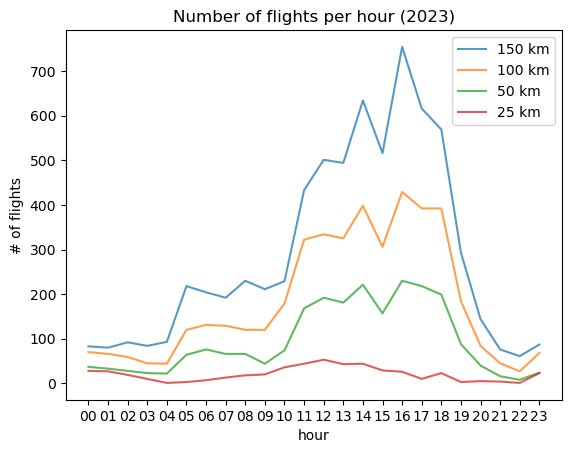

In [67]:
def query(min_r):

    return f'''
    Select 
        strftime('%H', mintime) as hour
        ,count(flightnumber) as counter
    from flights_distinct
    Where min_r < {min_r}
    Group By strftime('%H', mintime)
    '''

import matplotlib.ticker as ticker
for i in [150, 100, 50, 25]:
    flights_per_day = sqldf(query(i))
    plt.plot(flights_per_day.hour, flights_per_day.counter, label = f'{i} km', alpha = 0.75)
    plt.title('Number of flights per hour (2023)')
plt.xlabel('hour')
plt.ylabel('# of flights')
plt.legend()
# Customizing the x-axis to show Mo-Su
#days_of_week = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
#plt.gca().xaxis.set_major_locator(ticker.FixedLocator([1, 2, 3, 4, 5, 6, 7]))
#plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(days_of_week))
#plt.savefig('saved_figures/flights_per_hour_2023.pdf')
#flights_per_day
#flights_per_day